<a href="https://colab.research.google.com/github/snburgos/lecturasIIC3633-2021/blob/main/Pr%C3%A1cticos/Semana%203/pyreclab_svd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica de Sistemas Recomendadores: pyreclab - Funk's SVD

En este práctico implementaremos un recomendador basado en un algoritmo de factorización matricial propuesto por [Simon Funk](https://sifter.org/simon/journal/20061211.html).

Volveremos a utilizar la biblioteca de Python [pyreclab](https://github.com/gasevi/pyreclab), desarrollado por los Laboratorios IALab y SocVis de la Pontificia Universidad Católica de Chile.

**Adaptado por**: Vladimir Araujo

**Material original de**: Denis Parra, Gabriel Sepúlveda, Antonio Ossa, Manuel Cartagena


## Configuración inicial

**Paso 1:** Descargue directamente a Colab los archivos del dataset ejecutando las siguientes 3 celdas:

In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    236      0 --:--:--  0:00:01 --:--:--   236
100 1546k  100 1546k    0     0   818k      0  0:00:01  0:00:01 --:--:--  818k


In [2]:
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    483      0 --:--:-- --:--:-- --:--:--   482
100  385k  100  385k    0     0   387k      0 --:--:-- --:--:-- --:--:--  387k


In [3]:
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1763      0 --:--:-- --:--:-- --:--:--  1763
100  230k  100  230k    0     0   608k      0 --:--:-- --:--:-- --:--:--  608k


**Paso 2**: Instalamos [`pyreclab`](https://github.com/gasevi/pyreclab) y [`seaborn`](https://seaborn.pydata.org/index.html) utilizando `pip`.

In [4]:
!pip install pyreclab --upgrade
!pip install seaborn --upgrade

In [4]:
import pandas as pd
import pyreclab
import seaborn as sns
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="whitegrid")

## Antes de recomendar

**Paso 3**: Los archivos `u2.base` y `u2.test` tienen tuplas (usuario, item, rating, timestamp), que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/). Revisemos cómo es uno de estos archivos y luego haremos gráficos que nos permitan sacar conclusiones a partir del mismo.

In [5]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [7]:
# Ahora queremos realizar una observación rápida de los datos
df_train.describe()

,userid,itemid,rating,timestamp
count,80000.000000,80000.000000,80000.000000,8.000000e+04
mean,494.508137,424.990487,3.526463,8.835467e+08
std,276.879511,330.564093,1.124429,5.379549e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,269.000000,174.000000,3.000000,8.794471e+08
50%,500.000000,321.000000,4.000000,8.828278e+08
75%,744.000000,630.000000,4.000000,8.884652e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


Por otra parte, para obtener información adicional de cada película tal como **título**, **fecha de lanzamiento**, **género**, etc., cargaremos el archivo de items descargado (`u.item`) para poder mapear cada identificador de ítem al conjunto de datos que lo describe. Revisemos el contenido de este archivo

In [6]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [7]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [10]:
# Realizamos una inspección sobre estos datos (.info())
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musica

In [8]:
# Ejemplo de cómo visualizar titulos de peliculas en base a sus IDs
pelis = [5,4,1]
df_items.loc[pelis]['title']

movieid
5       Copycat (1995)
4    Get Shorty (1995)
1     Toy Story (1995)
Name: title, dtype: object

**Paso 4:** Generemos algunos gráficos en relación a las películas.

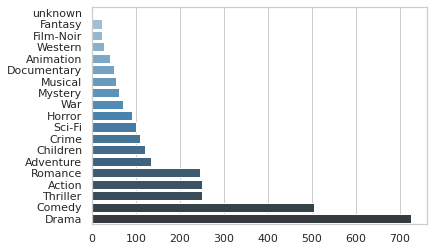

In [9]:
#Ignorar el warning
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

genre_count = df_items[genre_columns].sum().sort_values()

sns.barplot(x=genre_count.values, y=genre_count.index, label="Total", palette="Blues_d")

Antes de trabajar con SVD, responda las siguientes preguntas.

**Pregunta:** Explique cómo funciona SVD (como modelo, no piense en la implementación), y cómo funciona el método `train()` en  `pyreclab`





**Respuesta:**

SVD funciona a partir de una matriz $R$ de usuarios e items con ratings como valores. Como la matriz $R$ es _sparse_ o está incompleta, se busca una forma se factorizarla de la forma $R = M \Sigma U^T$. Las matrices M y U están compuestas por los vectores $p_u$ y $q_i$ donde estos son vectores de un usuario $u$ y vectores de un item $i$. Entonces, la solución de Simon Funk consiste en encontrar $M$ y $U$ a través de un método de óptimización minimizando el error al realizar el producto punto entre $p_u$ y $q_i$.

El método train recibe como parámetros el número de factores, un máximo de iteraciones, una tasa de aprendizaje y un $\lambda$ que es un parámetro de regularización para que no ocurra overfitting. Con estos parámetros, se calcula la función objetivo a partir de ciertos $p_u$ y $q_i$. Luego, se suma la tasa de aprendizaje y el $\lambda$ con tal de intentar de minimizar la función objetivo cambiando $p_u$ y $q_i$. Finalmente, este proceso se repite hasta que la función objetivo converga o le alcance el máximo de iteraciones.

## SVD

**Paso 5**: Tome un usuario, cualquiera, del dataset y reporte parte de sus gustos explícitamente (es decir, nombre de las películas, género, etc., no id). Para este mismo usuario, revise explícitamente las recomendaciones al llegar a la parametrización que reporta las mejores métricas.

In [10]:
user_id = 2
user_df = df_train[df_train['userid'] == user_id]

df_items.loc[user_df['itemid'].values]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
13,Mighty Aphrodite (1995),30-Oct-1995,NaN,http://us.imdb.com/M/title-exact?Mighty%20Aphr...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
19,Antonia's Line (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Antonia%20(1995),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
127,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
237,Jerry Maguire (1996),13-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Jerry%20Magui...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
251,Shall We Dance? (1996),11-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Shall%20we%20...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
255,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
257,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [12]:
# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# Entrenamiento del modelo
svd.train(factors=100, maxiter=100, lr=0.01, lamb=0.1)

In [13]:
# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print('MAE: {}\nRMSE: {}'.format(mae, rmse))

MAE: 0.7204950260383605
RMSE: 0.9149616514668482


In [14]:
# Testing de recomendaciones
top_n = 20

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.11503772980249265
NDCG@20: 0.062329092937022976


In [17]:
# Calcular las recomendaciones para el usuario escogido
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

Recommendation for user 2: [1512, 1449, 408, 1367, 169, 483, 1467, 641, 480, 1398, 318, 114, 12, 134, 199, 611, 64, 603, 192, 513]


In [18]:
# Ver explicitamente las recomendaciones para un usuario
df_items.loc[ranking]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1512,"World of Apu, The (Apur Sansar) (1959)",05-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Apur%20Sansar...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1449,Pather Panchali (1955),22-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Pather%20Panc...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
408,"Close Shave, A (1995)",28-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Close%20Shave...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1367,Faust (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Faust%20%2819...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
169,"Wrong Trousers, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Wrong%20Trous...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
483,Casablanca (1942),01-Jan-1942,NaN,http://us.imdb.com/M/title-exact?Casablanca%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
641,Paths of Glory (1957),01-Jan-1957,NaN,http://us.imdb.com/M/title-exact?Paths%20of%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
480,North by Northwest (1959),01-Jan-1959,NaN,http://us.imdb.com/M/title-exact?North%20by%20...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


**Paso 6:** Pruebe distintos valores de los parámetros de entrenamiento del algoritmo SVD:
- Número de factores
- Número de iteraciones máxima
- Learning rate
- Lambda

Describa cómo estos afectan las métricas y las recomendaciones hechas para el usuario que escogió:

## Cambiando factors

In [19]:
top_n = 5
factors = [100, 500, 1000]
maprec_values = [] # para almacenar resultados de MAP
ndcg_values = [] # para almacenar valores de NDCG@5

for f in factors:
    svd.train(factors=f, maxiter=100, lr=0.01, lamb=0.1)

    recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                            dlmchar=b'\t',
                                            header=False,
                                            usercol=0,
                                            itemcol=1,
                                            ratingcol=2,
                                            topn=top_n,
                                            relevance_threshold=2,
                                            includeRated=False)

    maprec_values.append(maprec)
    ndcg_values.append(ndcg)
    ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
    print(f'Recomendación con {f} factors:\n{df_items.loc[ranking]}\n')

print(f'MAP: {maprec_values}')
print(f'NDCG@5: {ndcg_values}')

Recomendación con 100 factors:
                                          title release_date  ...  War Western
movieid                                                       ...             
1449                     Pather Panchali (1955)  22-Mar-1996  ...    0       0
1467       Saint of Fort Washington, The (1993)  01-Jan-1993  ...    0       0
1512     World of Apu, The (Apur Sansar) (1959)  05-Apr-1996  ...    0       0
169                  Wrong Trousers, The (1993)  01-Jan-1993  ...    0       0
1558                           Aparajito (1956)  29-Mar-1996  ...    0       0

[5 rows x 23 columns]

Recomendación con 500 factors:
                                          title release_date  ...  War Western
movieid                                                       ...             
408                       Close Shave, A (1995)  28-Apr-1996  ...    0       0
169                  Wrong Trousers, The (1993)  01-Jan-1993  ...    0       0
1512     World of Apu, The (Apur Sansar) (195

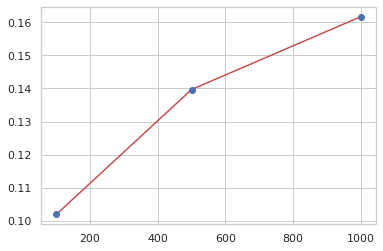

In [20]:
plt.plot(factors, maprec_values, 'r-')
plt.plot(factors, maprec_values, 'bo')
plt.show()

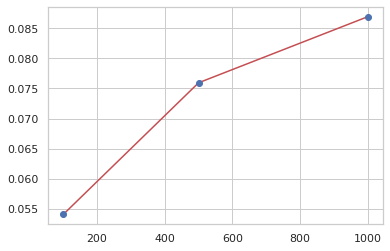

In [21]:
plt.plot(factors, ndcg_values, 'r-')
plt.plot(factors, ndcg_values, 'bo')
plt.show()

Se puede observar que al aumentar el número de factores (hasta 1000) las métricas de precisión aumentan.

## Cambiando maxiter

In [15]:
top_n = 5
max_iter = [50, 100, 200]
maprec_values = [] # para almacenar resultados de MAP
ndcg_values = [] # para almacenar valores de NDCG@5

for m in max_iter:
    svd.train(factors=1000, maxiter=m, lr=0.01, lamb=0.1)

    recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                            dlmchar=b'\t',
                                            header=False,
                                            usercol=0,
                                            itemcol=1,
                                            ratingcol=2,
                                            topn=top_n,
                                            relevance_threshold=2,
                                            includeRated=False)

    maprec_values.append(maprec)
    ndcg_values.append(ndcg)
    ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
    print(f'Recomendación con {m} maxiter:\n{df_items.loc[ranking]}\n')

print(f'MAP: {maprec_values}')
print(f'NDCG@5: {ndcg_values}')

Recomendación con 50 maxiter:
                              title release_date  ...  War Western
movieid                                           ...             
408           Close Shave, A (1995)  28-Apr-1996  ...    0       0
318         Schindler's List (1993)  01-Jan-1993  ...    1       0
483               Casablanca (1942)  01-Jan-1942  ...    1       0
1449         Pather Panchali (1955)  22-Mar-1996  ...    0       0
169      Wrong Trousers, The (1993)  01-Jan-1993  ...    0       0

[5 rows x 23 columns]

Recomendación con 100 maxiter:
                                          title release_date  ...  War Western
movieid                                                       ...             
1449                     Pather Panchali (1955)  22-Mar-1996  ...    0       0
408                       Close Shave, A (1995)  28-Apr-1996  ...    0       0
169                  Wrong Trousers, The (1993)  01-Jan-1993  ...    0       0
1512     World of Apu, The (Apur Sansar) (1959)  05

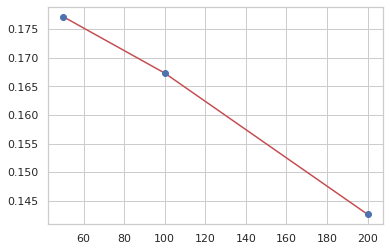

In [17]:
plt.plot(max_iter, maprec_values, 'r-')
plt.plot(max_iter, maprec_values, 'bo')
plt.show()

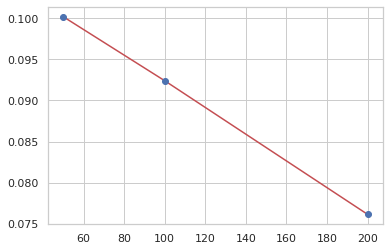

In [18]:
plt.plot(max_iter, ndcg_values, 'r-')
plt.plot(max_iter, ndcg_values, 'bo')
plt.show()

Al aumentar maxiter las preciciones disminuyen, por lo que con 50 máximas iteraciones se obtiene el mejor resultado.

## Cambiando lr

In [19]:
top_n = 5
learning_rate = [0.001, 0.01, 0.1]
maprec_values = [] # para almacenar resultados de MAP
ndcg_values = [] # para almacenar valores de NDCG@5

for lr in learning_rate:
    svd.train(factors=1000, maxiter=50, lr=lr, lamb=0.1)

    recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                            dlmchar=b'\t',
                                            header=False,
                                            usercol=0,
                                            itemcol=1,
                                            ratingcol=2,
                                            topn=top_n,
                                            relevance_threshold=2,
                                            includeRated=False)

    maprec_values.append(maprec)
    ndcg_values.append(ndcg)
    ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
    print(f'Recomendación con {lr} lr:\n{df_items.loc[ranking]}\n')

print(f'MAP: {maprec_values}')
print(f'NDCG@5: {ndcg_values}')

Recomendación con 0.001 lr:
                              title release_date  ...  War Western
movieid                                           ...             
169      Wrong Trousers, The (1993)  01-Jan-1993  ...    0       0
134             Citizen Kane (1941)  01-Jan-1941  ...    0       0
1607       Hurricane Streets (1998)  01-Jan-1998  ...    0       0
603              Rear Window (1954)  01-Jan-1954  ...    0       0
1647                 Hana-bi (1997)  20-Mar-1998  ...    0       0

[5 rows x 23 columns]

Recomendación con 0.01 lr:
                              title release_date  ...  War Western
movieid                                           ...             
408           Close Shave, A (1995)  28-Apr-1996  ...    0       0
1449         Pather Panchali (1955)  22-Mar-1996  ...    0       0
169      Wrong Trousers, The (1993)  01-Jan-1993  ...    0       0
318         Schindler's List (1993)  01-Jan-1993  ...    1       0
12       Usual Suspects, The (1995)  14-Aug-1995  

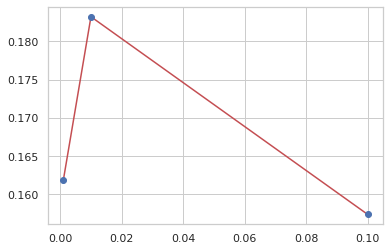

In [20]:
plt.plot(learning_rate, maprec_values, 'r-')
plt.plot(learning_rate, maprec_values, 'bo')
plt.show()

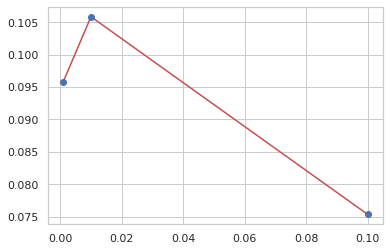

In [21]:
plt.plot(learning_rate, ndcg_values, 'r-')
plt.plot(learning_rate, ndcg_values, 'bo')
plt.show()

El mejor learning rate obtenido es para 0.01. Para un valor chico como 0.001 se podría no llegar al valor óptimo y para 0.1 el learning rate es muy grande y se puede pasar del valor óptimo.

## Cambiando lamb

In [22]:
top_n = 5
lambd = [0.01, 0.1, 1]
maprec_values = [] # para almacenar resultados de MAP
ndcg_values = [] # para almacenar valores de NDCG@5

for l in lambd:
    svd.train(factors=1000, maxiter=60, lr=0.01, lamb=l)

    recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                            dlmchar=b'\t',
                                            header=False,
                                            usercol=0,
                                            itemcol=1,
                                            ratingcol=2,
                                            topn=top_n,
                                            relevance_threshold=2,
                                            includeRated=False)

    maprec_values.append(maprec)
    ndcg_values.append(ndcg)
    ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
    print(f'Recomendación con {l} lambd:\n{df_items.loc[ranking]}\n')

print(f'MAP: {maprec_values}')
print(f'NDCG@5: {ndcg_values}')

Recomendación con 0.01 lambd:
                              title release_date  ...  War Western
movieid                                           ...             
603              Rear Window (1954)  01-Jan-1954  ...    0       0
253         Pillow Book, The (1995)  13-Jun-1997  ...    0       0
134             Citizen Kane (1941)  01-Jan-1941  ...    0       0
12       Usual Suspects, The (1995)  14-Aug-1995  ...    0       0
180           Apocalypse Now (1979)  01-Jan-1979  ...    1       0

[5 rows x 23 columns]

Recomendación con 0.1 lambd:
                                    title release_date  ...  War Western
movieid                                                 ...             
169            Wrong Trousers, The (1993)  01-Jan-1993  ...    0       0
408                 Close Shave, A (1995)  28-Apr-1996  ...    0       0
318               Schindler's List (1993)  01-Jan-1993  ...    1       0
64       Shawshank Redemption, The (1994)  01-Jan-1994  ...    0       0
483       

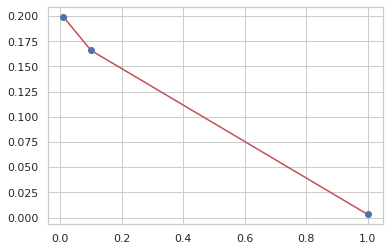

In [23]:
plt.plot(lambd, maprec_values, 'r-')
plt.plot(lambd, maprec_values, 'bo')
plt.show()

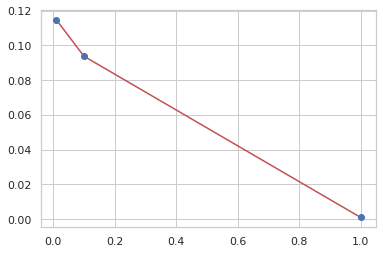

In [24]:
plt.plot(lambd, ndcg_values, 'r-')
plt.plot(lambd, ndcg_values, 'bo')
plt.show()

Para el lambda se observa que al darle menos peso se obtienen mejores resultados.

Al cambiar cada métrica por separado se obtienen siempre distintas precisiones y distintas listas recomendadas. Hay ciertas películas que se repiten, pero las recomendaciones en general cambian. Esto implica lo importante que son los parámetros, ya que cualquier cambio en alguno de ellos va a ser un cambio en el resultado. Hay que considerar que los resultados son para un usuario en específico, por lo que no representa la realidad del conjunto de usuarios.

**Paso 7:** Genere un gráfico explorando todos los parámetros que ofrece el modelo `SVD`, donde se grafiquen los valores probados para cada parámetro y el RMSE obtenido para cada uno. Debe probar una cantidad razonable de valores buscando la mejor parametrización y entregar el notebook con dicha parametrización.



In [25]:
# Ejemplo
factor_values = [100, 150, 200] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for f in factor_values:
  svd.train(factors=f, maxiter=100, lr=0.01, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7202897338242291, 0.7203529352744754, 0.7201699082099029]
[0.913955239964925, 0.9135890999255983, 0.9136648136530943]


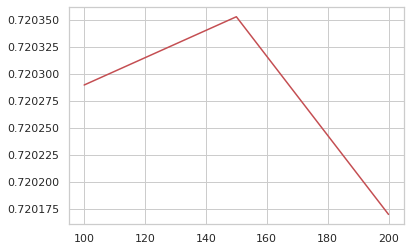

In [26]:
plt.plot(factor_values, mae_values, 'r-')
plt.show()

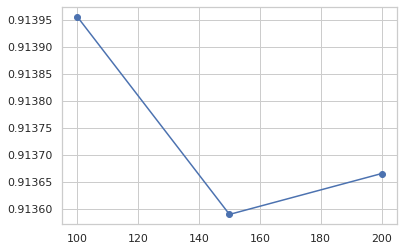

In [27]:
plt.plot(factor_values, rmse_values, 'bo-')
plt.show()

**Paso 8:** Pruebe con otros valores y/o parámetros:

In [28]:
maxiter_values = [100, 150, 200] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for maxiter in maxiter_values:
  svd.train(factors=150, maxiter=maxiter, lr=0.01, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7207007040157544, 0.7207314023806994, 0.721189786570177]
[0.9142696738977806, 0.9144758911321773, 0.9149678261986232]


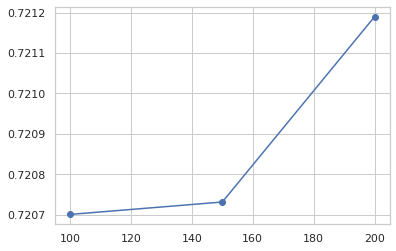

In [29]:
plt.plot(maxiter_values, mae_values, 'bo-')
plt.show()

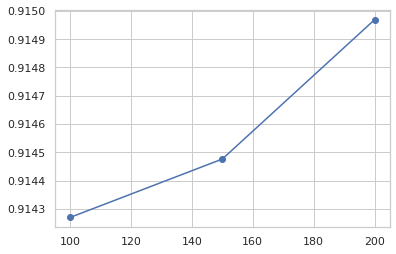

In [30]:
plt.plot(maxiter_values, rmse_values, 'bo-')
plt.show()

In [31]:
lr_values = [0.001, 0.01, 0.1] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for lr in lr_values:
  svd.train(factors=150, maxiter=100, lr=lr, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7431344532926295, 0.7202348179721496, 0.7644391367577758]
[0.9398616102455553, 0.9138214516213427, 0.9617681998377822]


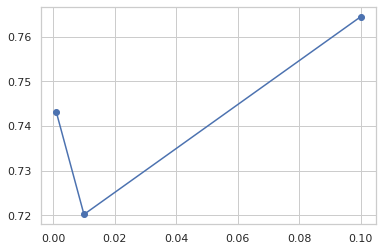

In [32]:
plt.plot(lr_values, mae_values, 'bo-')
plt.show()

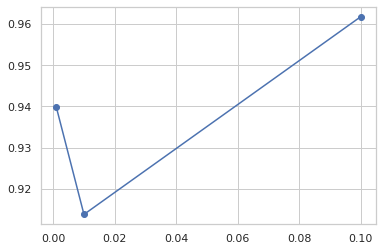

In [33]:
plt.plot(lr_values, rmse_values, 'bo-')
plt.show()

In [34]:
lamb_values = [0.01, 0.1, 1] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for lamb in lamb_values:
  svd.train(factors=150, maxiter=100, lr=0.01, lamb=lamb)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7716424123242274, 0.7202202406370938, 0.8057665538521955]
[0.9829738308162185, 0.9137672721334569, 0.9894847442660558]


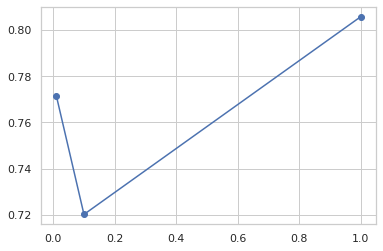

In [35]:
plt.plot(lamb_values, mae_values, 'bo-')
plt.show()

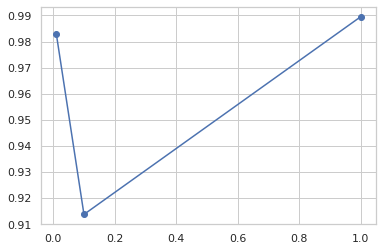

In [36]:
plt.plot(lamb_values, rmse_values, 'bo-')
plt.show()